In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import os
import numpy as np
import cv2
from torch.autograd import Variable
from torch.utils.data import DataLoader
from pandas import DataFrame

class Linear(nn.Module):

    def __init__(self, num_classes=2):

        super(Linear, self).__init__()

        self.number_class = num_classes

        _size_image = 100 * 100
        _num1 = 250
        _num2 = 100
        _num3 = 50

        self.fc1 = nn.Linear(_size_image, _num1, bias=True)
        self.fc2 = nn.Linear(_num1, _num2, bias=True)
        self.fc3 = nn.Linear(_num2, _num3, bias=True)
        self.fc4 = nn.Linear(_num3, num_classes, bias=True)

        self.fc_layer1 = nn.Sequential(self.fc1,nn.ReLU(True))
        self.fc_layer2 = nn.Sequential(self.fc2,nn.ReLU(True))
        self.fc_layer3 = nn.Sequential(self.fc3,nn.ReLU(True))
        self.fc_layer4 = nn.Sequential(self.fc4,nn.Sigmoid())

        self.classifier = nn.Sequential(self.fc_layer1, self.fc_layer2, self.fc_layer3,self.fc_layer4)

    def _initialize_weight(self):
        n1 = self.fc1.in_features
        #self.fc1.weight.data.uniform_(- 1.0 / math.sqrt(n1), 1.0 / math.sqrt(n1))
        nn.init.kaiming_normal(self.fc1.weight.data)   # Kaiming He initialization for relu
        if self.fc1.bias is not None:
            self.fc1.bias.data.zero_()

        n2 = self.fc2.in_features
        nn.init.kaiming_normal(self.fc2.weight.data)   # Kaiming He initialization for relu
        if self.fc2.bias is not None:
            self.fc2.bias.data.zero_()

        n3 = self.fc3.in_features
        nn.init.kaiming_normal(self.fc3.weight.data)  # Kaiming He initialization for relu
        if self.fc3.bias is not None:
            self.fc3.bias.data.zero_()

        n4 = self.fc3.in_features
        nn.init.xavier_normal(self.fc4.weight.data)   # Xavier initialization for sigmoid

        if self.fc4.bias is not None:
            self.fc4.bias.data.zero_()

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.classifier(x)

        return x
# -----------------------------------------------------------------------------
# load dataset
# -----------------------------------------------------------------------------

class HoHDataset:
    def __init__(self,path):
        set = []
        y = 0
        for a, b, file in os.walk(path):
            for i in file:
                str1 = a + "/" + str(i)
                t = cv2.imread(str1)
                t = cv2.cvtColor(t, cv2.COLOR_BGR2GRAY)
                t = t / 255
                t = t.reshape(10000)
                temp = []
                for j in range(10000):
                    temp.append(t[j].tolist())
                temp.append(y - 1)
                set.append(temp)
                if len(set) == 1024:   # for batch size
                    break
            y += 1
        print("load from %s : %d" % (path,len(set)))

        set = np.asarray(set)
        set.astype(float)
        self.len = set.shape[0]
        self.x_data = torch.from_numpy(set[:, 0:-1]).float()  # float
        self.y_data = torch.from_numpy(set[:, [-1]]).float() # float

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.len

set_train = HoHDataset("horse-or-human/train")
set_test = HoHDataset("horse-or-human/validation")
loader_train = DataLoader(dataset=set_train, batch_size=64, shuffle=True, num_workers=0)
loader_test = DataLoader(dataset=set_test, batch_size=256, shuffle=True, num_workers=0)

epoch = 1200
l_rate = 0.001
w_decay = 0.001
sc_gamma = 0.9
sc_step = 35
torch.manual_seed(1)
torch.cuda.manual_seed_all(1)
#----------------------------------------------------------------------------
num_classes = 1
model = Linear(num_classes=num_classes).float()  # load neural network model  # float

bCuda = 1

if bCuda:
    model.cuda()

optimizer = optim.SGD(model.parameters(),lr=l_rate,weight_decay=w_decay) # optimization algorithm, L2 reqularization
#scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer,lr_lambda=lambda epoch: 1 / (epoch+1))
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=sc_step, gamma=sc_gamma) # lr scheduler
#objective = nn.CrossEntropyLoss()
objective = nn.BCELoss()
# -----------------------------------------------------------------------------
# function for training the model
# -----------------------------------------------------------------------------
def train():
    loss_train = []
    correct = 0
    model.train()
    for idx_batch, (data, target) in enumerate(loader_train):

        if bCuda:
            data, target = data.cuda(), target.cuda()

        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()

        output = model(data)
        loss = objective(output,target)

        loss.backward()
        optimizer.step()

        loss_train_batch = loss.item() / len(data)
        loss_train.append(loss_train_batch)

        np_output = output.cpu().detach().numpy()
        np_target = target.cpu().detach().numpy()
        pred = []
        for j in range(np_output.shape[0]):
            if np_output[j] >= 0.5:
                pred.append(1)
            else:
                pred.append(0)
            if pred[j] == np_target[j]:
                correct += 1

    scheduler.step()
    loss_train_meant = np.mean(loss_train)
    loss_train_stdt = np.std(loss_train)
    accuracy_train = 100. * float(correct) / len(loader_train.dataset)
    for param_group in optimizer.param_groups:
        tlr = param_group['lr']
    return {'loss_train_mean': loss_train_meant, 'loss_train_std': loss_train_stdt, 'current_lr' : tlr, 'accuracy_train' : accuracy_train}


# -----------------------------------------------------------------------------
# function for testing the model
# -----------------------------------------------------------------------------
def test():
    loss_test = 0
    correct = 0

    model.eval()

    for idx_batch, (data, target) in enumerate(loader_test):

        if bCuda:
            data, target = data.cuda(), target.cuda()

        data, target = Variable(data), Variable(target)

        output = model(data)
        loss = objective(output, target)
        loss_test += loss.item()

        np_output = output.cpu().detach().numpy()
        np_target = target.cpu().detach().numpy()
        pred = []
        for j in range(np_output.shape[0]):
            if np_output[j] >= 0.5:
                pred.append(1)
            else:
                pred.append(0)
            if pred[j] == np_target[j]:
                correct+=1

    loss_testt = loss_test / len(loader_test.dataset)
    accuracy_testt = 100. * float(correct) / len(loader_test.dataset)

    return {'loss_test': loss_testt, 'accuracy_test': accuracy_testt}
# -----------------------------------------------------------------------------
# iteration for the epoch
# -----------------------------------------------------------------------------


load from horse-or-human/train : 1024
load from horse-or-human/validation : 256


[epoch :    0] loss : (training) 0.010816 , (testing) 0.002708, accuracy : (training) 51.171875 (testing) 50.000000
[epoch :   50] loss : (training) 0.010620 , (testing) 0.002632, accuracy : (training) 51.562500 (testing) 50.000000
[epoch :  100] loss : (training) 0.010395 , (testing) 0.002526, accuracy : (training) 60.253906 (testing) 69.531250
[epoch :  150] loss : (training) 0.010065 , (testing) 0.002372, accuracy : (training) 67.773438 (testing) 85.546875
[epoch :  200] loss : (training) 0.009598 , (testing) 0.002154, accuracy : (training) 72.167969 (testing) 87.500000
[epoch :  250] loss : (training) 0.008983 , (testing) 0.001879, accuracy : (training) 75.488281 (testing) 88.281250
[epoch :  300] loss : (training) 0.008372 , (testing) 0.001629, accuracy : (training) 76.367188 (testing) 86.328125
[epoch :  350] loss : (training) 0.007840 , (testing) 0.001442, accuracy : (training) 77.734375 (testing) 87.109375
[epoch :  400] loss : (training) 0.007430 , (testing) 0.001315, accuracy

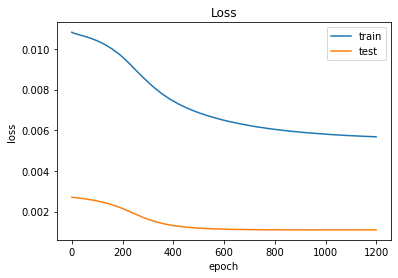

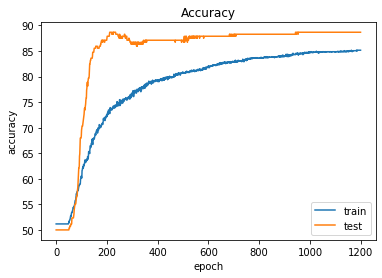

,loss,accuracy
training,0.0057,85.1562
validation,0.0011,88.6719


In [12]:
eplist = []
loss_train_mean = []
loss_test = []
acc_train = []
accuracy_test = []
result = []

max_acc = 0
min_loss = 1
for e in range(epoch):
    eplist.append(e)
    result_train = train()
    result_test = test()
    loss_train_mean.append(result_train['loss_train_mean'])
    loss_test.append(result_test['loss_test'])
    acc_train.append(result_train['accuracy_train'])
    accuracy_test.append(result_test['accuracy_test'])
    if result_test['accuracy_test'] >= max_acc:
        max_acc = result_test['accuracy_test']
    if result_test['loss_test'] <= min_loss:
        min_loss = result_test['loss_test']
    if e == epoch-1 :
        result.append(result_train['loss_train_mean'])
        result.append(result_train['accuracy_train'])
        result.append(result_test['loss_test'])
        result.append(result_test['accuracy_test'])
        print("complete")
    if e % 50 == 0:
        print("[epoch : %4d] loss : (training) %f , (testing) %f, accuracy : (training) %f (testing) %f"% (e,result_train['loss_train_mean'],
                                                                                                                          result_test['loss_test'],
                                                                                                                          result_train['accuracy_train'],
                                                                                                                          result_test['accuracy_test']))
            

plt.plot(eplist,loss_train_mean)
plt.plot(eplist,loss_test)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss')
plt.legend(["train","test"])
plt.show()

plt.plot(eplist,acc_train)
plt.plot(eplist,accuracy_test)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy')
plt.legend(["train","test"])
plt.show()

data = {'loss':[np.round(result[0],4),np.round(result[2],4)],'accuracy':[np.round(result[1],4),np.round(result[3],4)]}
frame = DataFrame(data,index=["training","validation"])
frame
